# **CoronaVision.ipynb**

Calculating the group density and number of people in an image using computer vision and machine learning.
Some code cells can be **skipped**.

In [ ]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import scipy.io
import pandas as pd
import csv
import cv2
import io
import re
import random
from PIL import Image
from matplotlib import cm
from keras.preprocessing.image import ImageDataGenerator
from functools import partial
from google.colab import output

import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)

2.8.0


---

## Linking the Google Drive

Next we mount the **Google Drive**. If you get an error that the folder couldn't be found, you first need to add a shortcut of the shared drive to your own drive.

See here: https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


---

## Helper Functions

**Needs to be run.** Just some useful things that make my life easier.

In [ ]:
# "folder" files: the folder containing the files
# "files"  files: list of all files in the folder

# select a different path using base_path
base_path     = 'gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/test_data'
base_path_old = base_path + '_old'

img_folder = pathlib.Path(base_path + '/images/')
dmp_folder = pathlib.Path(base_path + '/density-maps/')
csv_folder = pathlib.Path(base_path_old + '/ground-truth-csv/')
mat_folder = pathlib.Path(base_path_old + '/ground-truth/')

img_files = list(sorted(img_folder.glob('*.jpg')))
dmp_files = list(sorted(dmp_folder.glob('*.png')))
csv_files = list(sorted(csv_folder.glob('*.csv')))
mat_files = list(sorted(mat_folder.glob('*.mat')))

img_files = [str(i) for i in img_files]
dmp_files = [str(i) for i in dmp_files]
csv_files = [str(i) for i in csv_files]
mat_files = [str(i) for i in mat_files]

In [ ]:
# Get ID from file path
# -- for path = 'gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_A/train_data/images/IMG_131.jpg'
# -- gives 131
def get_id_from_path(path):
  result = re.findall('_\d{1,3}', path)[0][1:]
  return result

test_path = 'gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_A/train_data/images/IMG_131.jpg'
get_id_from_path(test_path)

'131'

In [ ]:
# helpful commands:

# list all files in directory
# !ls gdrive/MyDrive/TechLabs\ -\ Group\ 13/

# unzip file in google drive
# !unzip gdrive/MyDrive/TechLabs\ -\ Group\ 13/ShanghaiTech/archive.zip -d gdrive/MyDrive/TechLabs\ -\ Group\ 13/ShanghaiTech/

---
---
# **1. Automatically generating density maps**

First we build a model to generate a density map from an image

---

## Cleaning the Data

But before we can start, we need to clean the data. 

1.   Load .mat file
2.   Get data from .mat file
3.   Save data as .csv file in respective **ground-truth-csv**

(Data is already cleaned, code does not need to be run again)

In [ ]:
### can be skipped

# function to read the coordinates from a .mat file
def clean_mat(mat_file):
  current_iter = mat_file['image_info']

  # we do not know at which 'depth' the coordinates are saved,    (i.e. sometimes it [[[[3, 3]]]], other times [[2,2]])
  # so we recursively go deeper into the array until coordinates are first found
  # stop when a float is found at 2 layers deeper than the current layer
  while True:
    current_iter = current_iter[0]                  # go a layer deeper

    if isinstance(current_iter[0][0], np.floating): # is there a np.floating type number two layers in?
      break

  return current_iter

In [ ]:
### can be skipped

# convert all .mat files from a folder to .csv
for fn in mat_files:

  # load and clean data
  raw_data = scipy.io.loadmat(fn)
  cleaned_data = clean_mat(raw_data)

  # get id from path
  id = get_id_from_path(str(fn))

  # where to save the csv
  csv_path = str(csv_folder) + '/CSVGT_IMG_' + id + '.csv'

  # save the csv to csv_path
  df = pd.DataFrame(cleaned_data)
  df.to_csv(csv_path, index=False, header=None)

  print(fn, cleaned_data.shape)

---

## Constructing the density maps

For the next step we generate the density maps.

**gaussian_filter_density(gt)**
*   gt: list of coordinates/points
*   Returns the density map

(Density maps are already generated, code does not need to be run again)


In [ ]:
### can be skipped

# this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet ###
# https://github.com/leeyeehoo/CSRNet-pytorch/blob/ed29d895989c188cb913a9503721271c6cf1ab1f/make_dataset.ipynb ###
def gaussian_filter_density(gt):

    density = np.zeros(gt.shape, dtype=np.float32)

    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density    

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))

    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
            
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
        
    return density

In [ ]:
### can be skipped

# create a density map for all selected images
for img_path in img_files:

    # get number from file path
    id = get_id_from_path(str(img_path))

    # get .csv file for image
    csv_path = str(csv_folder) + '/CSVGT_IMG_' + id + '.csv'

    img = plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))

    with open(csv_path) as csv_open:

      # go through all coordinates
      for csv_line in csv_open.readlines():

          csv_string = csv_line.strip()
          x, y = csv_string.split(',')

          x = int(float(x))
          y = int(float(y))

          k[y, x] = 1.0

    # get density map for list of coordinates
    arr = gaussian_filter_density(k)

    # scale values between 0.0 - 1.0
    scaling = 1./np.max(arr)
    arr *= scaling

    # apply jet colormap
    # arr = cm.jet(arr) * 255.

    # convert array to csv
    img = Image.fromarray(np.uint8(arr))

    if img.mode != 'RGB':
      img = img.convert('RGB')

    # save density map to dmp_path
    dmp_path = str(dmp_folder) + '/IMG_' + id + '.jpg'
    img.save(dmp_path)
    print(dmp_path)

We found out that having the density maps as **images** is more useful than having them as .csv files. Sadly, we only found it out after already having generated all the .csv files. What we do now is **load all .csv files** again and **convert them to .png files**.

In [ ]:
### can be skipped

# convert all density map csv files to images

# get path to old csv files
dmp_csv_folder = pathlib.Path('gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data_old/density-maps-csv')

dmp_csv_files = list(sorted(dmp_csv_folder.glob('*.csv')))
dmp_csv_files = [str(i) for i in dmp_csv_files]

# count progress
counter = 0
goal = len(dmp_csv_files)

# go through all csv files
for dmp_csv in dmp_csv_files:

  # print progress
  print('[' + str(((counter * 100) // goal) + 1) + '%]', dmp_csv)

  # get id from filepath
  id = get_id_from_path(str(dmp_csv))

  # read csv as array
  arr = np.genfromtxt(str(dmp_csv), delimiter=",")

  # sqrt to get a more uniform distribution
  arr = np.sqrt(arr)

  # scale values between 0 - 255
  scaling = 255./np.max(arr)
  arr *= scaling

  # apply jet colormap
  # arr = cm.jet(arr) * 255.

  # convert array to csv
  img = Image.fromarray(np.uint8(arr))

  if img.mode != 'RGB':
    img = img.convert('RGB')

  # save image to image_path
  image_path = str(dmp_folder) + '/IMG_' + id + '.jpg'
  img.save(image_path)

  counter += 1

[1%] gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data_old/density-maps-csv/DM_1.csv
[1%] gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data_old/density-maps-csv/DM_10.csv
[1%] gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data_old/density-maps-csv/DM_100.csv
[1%] gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data_old/density-maps-csv/DM_101.csv
[2%] gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data_old/density-maps-csv/DM_102.csv
[2%] gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data_old/density-maps-csv/DM_103.csv
[2%] gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data_old/density-maps-csv/DM_104.csv
[2%] gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data_old/density-maps-csv/DM_105.csv
[3%] gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data_old/density-maps-csv/DM_106.csv
[3%] gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data_old/d

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply


[40%] gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data_old/density-maps-csv/DM_240.csv
[40%] gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data_old/density-maps-csv/DM_241.csv
[40%] gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data_old/density-maps-csv/DM_242.csv
[41%] gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data_old/density-maps-csv/DM_243.csv
[41%] gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data_old/density-maps-csv/DM_244.csv
[41%] gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data_old/density-maps-csv/DM_245.csv
[41%] gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data_old/density-maps-csv/DM_246.csv
[42%] gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data_old/density-maps-csv/DM_247.csv
[42%] gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data_old/density-maps-csv/DM_248.csv
[42%] gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/tra

---
## Creating the datasets

Here we build the datasets.

We save each image, density map and the number of people in seperate arrays. Both the images and the density maps get **scaled** to a set width and height, currently **256x256**.

`img_data = [image_1, image_2, ... image_n]`

`dmp_data = [densitymap_1, densitymap_2, ... densitymap_n]`

`ppl_data = [num_ppl_1, num_ppl_2, ... num_ppl_n]`

(Datasets have already been created, code does not need to be run again)

In [ ]:
### can be skipped

scaled_size = (256, 256)
img_data = []
dmp_data = []
ppl_data = []

# keep track of progress
counter = 0
goal = len(img_files)

for img in img_files:

  # get id from image
  id = get_id_from_path(img)

  # load image data
  img = cv2.imread(img)
  img = cv2.resize(img, scaled_size)
  img = np.array(img)

  img_data.append(img)


  # load corresponding density map
  dmp_path = str(dmp_folder) + '/IMG_' + id + '.jpg'

  dmp = cv2.imread(dmp_path)
  dmp = cv2.resize(dmp, scaled_size)
  dmp = np.array(dmp)

  # take only one channel from RGB
  dmp = dmp[:, :, 0]

  dmp_data.append(dmp)


  # get number of people in image
  csv_path = str(csv_folder) + '/CSVGT_IMG_' + id + '.csv'

  with open(csv_path) as csv_open:
    ppl = len(csv_open.readlines())

  ppl_data.append(ppl)

  counter += 1
  print(str((counter * 100) // goal) + '%')


# save, so we only have to generate them once
np.save(base_path + '/images.npy', img_data)
np.save(base_path + '/density_maps.npy', dmp_data)
np.save(base_path + '/people.npy', ppl_data)

---
## Loading the datasets

**Needs to be run.** We can now efficiently load the datasets.

In [ ]:
img_data_a_train = np.load('gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_A/train_data/images.npy', allow_pickle=True)
img_data_a_test  = np.load('gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_A/test_data/images.npy', allow_pickle=True)
img_data_b_train = np.load('gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data/images.npy', allow_pickle=True)
img_data_b_test  = np.load('gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/test_data/images.npy', allow_pickle=True)

dmp_data_a_train = np.load('gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_A/train_data/density_maps.npy', allow_pickle=True)
dmp_data_a_test  = np.load('gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_A/test_data/density_maps.npy', allow_pickle=True)
dmp_data_b_train = np.load('gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data/density_maps.npy', allow_pickle=True)
dmp_data_b_test  = np.load('gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/test_data/density_maps.npy', allow_pickle=True)

ppl_data_a_train = np.load('gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_A/train_data/people.npy', allow_pickle=True)
ppl_data_a_test  = np.load('gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_A/test_data/people.npy', allow_pickle=True)
ppl_data_b_train = np.load('gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/train_data/people.npy', allow_pickle=True)
ppl_data_b_test  = np.load('gdrive/MyDrive/TechLabs - Group 13/ShanghaiTech/part_B/test_data/people.npy', allow_pickle=True)

In [ ]:
img_data_a_train.shape, dmp_data_a_train.shape, ppl_data_a_train.shape

((300, 256, 256, 3), (300, 256, 256), (300,))

Now we combine the seperate datasets into one.

In [ ]:
img_data_train = []
dmp_data_train = []
ppl_data_train = []

img_data_test = []
dmp_data_test = []
ppl_data_test = []

img_data_train = np.append(img_data_a_train, img_data_b_train, axis=0)
img_data_test  = np.append(img_data_a_test, img_data_b_test, axis=0)

dmp_data_train = np.append(dmp_data_a_train, dmp_data_b_train, axis=0)
dmp_data_test  = np.append(dmp_data_a_test, dmp_data_b_test, axis=0)

ppl_data_train = np.append(ppl_data_a_train, ppl_data_b_train, axis=0)
ppl_data_test  = np.append(ppl_data_a_test, ppl_data_b_test, axis=0)

img_data_train.shape, dmp_data_train.shape, ppl_data_train.shape

((700, 256, 256, 3), (700, 256, 256), (700,))

All images and density maps have the same size, **256x256 pixels**. Let's take a look at a random sample.

1546
920
371
298
184


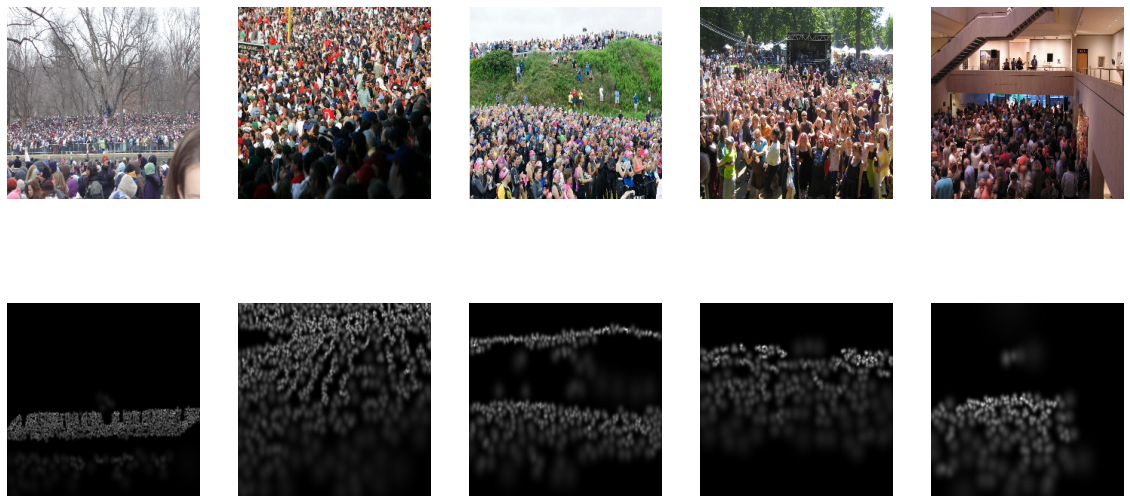

In [ ]:
### can be skipped
examples = 5

plt.figure(figsize=(20, 10))

# take some examples
for i in range(examples):

  # get current image and density map
  current_img = img_data_train[i]
  current_dmp = dmp_data_train[i]

  # show image
  ax = plt.subplot(2, examples, i + 1)
  plt.imshow(cv2.cvtColor(current_img, cv2.COLOR_BGR2RGB))
  plt.axis("off")

  # show density map
  ax = plt.subplot(2, examples, i + examples + 1)
  plt.imshow(cv2.cvtColor(current_dmp, cv2.COLOR_BGR2RGB))
  plt.axis("off")

  print(ppl_data_train[i])

---

## Building the architecture

**Needs to be run.** It is now time to create an architecture for the model.

In [ ]:
def build_model_dmp():

  # the shape of a single image
  img_shape = (256, 256, 3)

  # the layers that get added to the model
  layers_forwards  = [64, 128, 'M', 128, 256, 'M', 256, 512, 'M', 512, 512]
  layers_backwards = [512, 512, 'M', 256, 256, 'M', 128, 128, 'M', 64, 64]

  # build model
  model = None
  model = tf.keras.models.Sequential([])

  # scale down
  for layer in layers_forwards:

    # add max pooling layer
    if layer == 'M':
      model.add(tf.keras.layers.MaxPool2D())

    # add convolution 2d layer
    else:
      model.add(tf.keras.layers.Conv2D(layer, kernel_size = 3, dilation_rate = 2, activation = 'relu', padding='same'))

  # dense layers in the middle
  model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
  model.add(tf.keras.layers.Dense(1024, activation = 'relu'))

  # scale up
  for layer in layers_backwards:

    # add upscaling layer
    if layer == 'M':
      model.add(tf.keras.layers.UpSampling2D())

    # add backwards convolution 2d layer
    else:
      model.add(tf.keras.layers.Conv2DTranspose(layer, kernel_size = 3, dilation_rate = 2, activation = 'relu', padding='same'))


  # final backwards convolution, only one output channel
  model.add(tf.keras.layers.Conv2DTranspose(1, kernel_size = 3, activation = 'relu',  padding='same'))

  # resize to 256x256
  model.add(tf.keras.layers.Resizing(256, 256))

  return model

In [ ]:
# compile the model and give a summary
model_dmp = build_model_dmp()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model_dmp.build(input_shape = (None, 256, 256, 3))

model_dmp.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae', 'acc'],
    )

model_dmp.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 conv2d_41 (Conv2D)          (None, 256, 256, 128)     73856     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 128, 128, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 conv2d_43 (Conv2D)          (None, 128, 128, 256)     295168    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 64, 64, 256)      0         
 g2D)                                                 

---

## Training the model

Now that we have the built and compiled the architecture, we can finally train the model!

(Model has already been trained, code does not need to be run again)

In [ ]:
# train the model
n_epochs = 100

# normalize image data between 0 .. 255 for training
# currently nothing happens in this step
# still useful to have if you want to quickly change the intervals of the data
# img_data_training = img_data
# img_data_training = img_data_training.astype('float32')
# img_data_training = img_data_training / 255.

# normalize dmp data between 0 .. 255 for training
# currently nothing happens in this step
# dmp_data_training = dmp_data

history_dmp = model_dmp.fit(
    x = img_data_train,
    y = dmp_data_train,
    batch_size = 8,
    epochs = n_epochs,
    validation_split = 0.2,
    shuffle = True
    )

Epoch 1/100
70/70 [==============================] - 30s 365ms/step - loss: 7914.4990 - mae: 31.6441 - acc: 0.0998 - val_loss: 687.5540 - val_mae: 13.4218 - val_acc: 0.0638
Epoch 2/100
70/70 [==============================] - 24s 345ms/step - loss: 954.4639 - mae: 20.5336 - acc: 0.0427 - val_loss: 543.9859 - val_mae: 16.6618 - val_acc: 0.0609
Epoch 3/100
70/70 [==============================] - 24s 349ms/step - loss: 846.3643 - mae: 19.3704 - acc: 0.0423 - val_loss: 501.0696 - val_mae: 15.2693 - val_acc: 0.0607
Epoch 4/100
70/70 [==============================] - 24s 345ms/step - loss: 796.4478 - mae: 18.4715 - acc: 0.0436 - val_loss: 470.9766 - val_mae: 14.1726 - val_acc: 0.0605
Epoch 5/100
70/70 [==============================] - 24s 351ms/step - loss: 805.6215 - mae: 18.6734 - acc: 0.0423 - val_loss: 610.5189 - val_mae: 12.3963 - val_acc: 0.0615
Epoch 6/100
70/70 [==============================] - 24s 345ms/step - loss: 766.5602 - mae: 18.0476 - acc: 0.0423 - val_loss: 469.4103 - va

Let's see how training improved the accuracy.

(0.0, 2000.0)

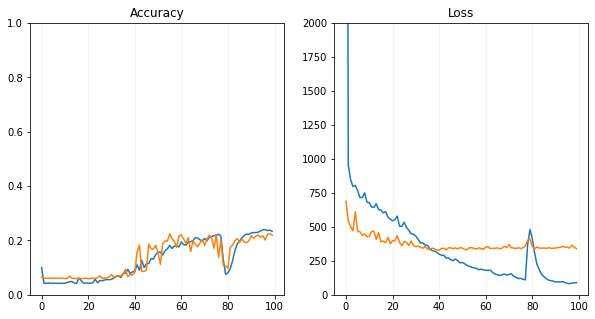

In [ ]:
# plot the history
accuracy_trn = history_dmp.history['acc']
accuracy_val = history_dmp.history['val_acc']
loss_trn = history_dmp.history['loss']
loss_val = history_dmp.history['val_loss']

# display original and prediction
plt.figure(figsize=(10, 5))

# show plots
ax1 = plt.subplot(1, 2, 1)
ax1.title.set_text('Accuracy')
plt.grid(axis='x', color='0.95')
plt.plot(accuracy_trn)
plt.plot(accuracy_val)
plt.ylim(bottom = 0, top = 1)

ax2 = plt.subplot(1, 2, 2)
ax2.title.set_text('Loss')
plt.grid(axis='x', color='0.95')
plt.plot(loss_trn)
plt.plot(loss_val)
plt.ylim(bottom = 0, top = 2000)

Let's also save the model, so we can skip training

In [ ]:
model_dmp.save('gdrive/MyDrive/TechLabs - Group 13/Models/density-map-model.h5')

---

## Using the model for prediction

Now that we have the model, we can look at some density maps it generates. 

(Optional)


In [ ]:
# load weights
model_dmp.load_weights('gdrive/MyDrive/TechLabs - Group 13/Models/density-map-model.h5')

In [ ]:
predictions = 5
offset = 0

# predict density map
img_pred = model_dmp.predict(img_data_train[offset:offset+predictions])
img_pred = img_pred.reshape((predictions, 256, 256))
img_pred = img_pred.astype('float32')

img_pred.shape

(5, 256, 256)

In [ ]:
# scale values between 0.0 and 1.0
for i in range(predictions):
  max_pre = np.max(img_pred[i])

  scaling = 1. / np.max(img_pred[i])
  img_pred[i] = img_pred[i] * scaling

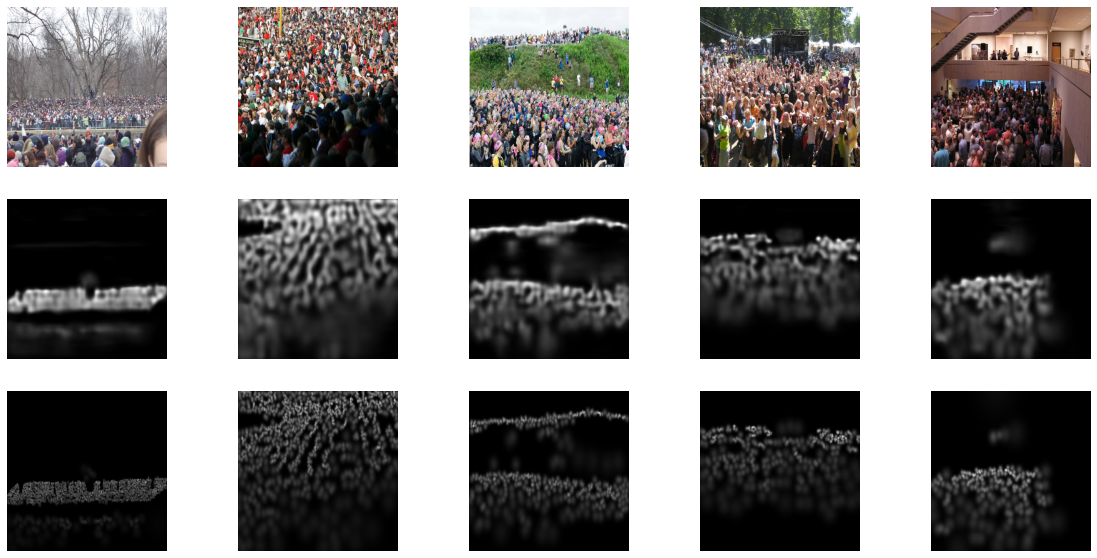

In [ ]:
# display original and prediction
plt.figure(figsize=(20, 10))

for i in range(predictions):

  # show image
  ax1 = plt.subplot(3, predictions, i+1)
  plt.imshow(cv2.cvtColor(img_data_train[i+offset], cv2.COLOR_BGR2RGB))
  plt.axis("off")

  # show predicted density map
  ax2 = plt.subplot(3, predictions, i+predictions+1)
  plt.imshow(cv2.cvtColor(img_pred[i], cv2.COLOR_BGR2RGB))
  plt.axis("off")

  # show predicted density map
  ax3 = plt.subplot(3, predictions, i+predictions+predictions+1)
  plt.imshow(cv2.cvtColor(dmp_data_train[i+offset], cv2.COLOR_BGR2RGB))
  plt.axis("off")

---

## Real World Examples

Let's see how the model performs on images it has not seen before.

(Optional)

In [ ]:
# Get test images
test_path = 'gdrive/MyDrive/TechLabs - Group 13/Test Images/'
test_folder = pathlib.Path(test_path)

test_files = list(sorted(test_folder.glob('*.jpg')))
test_files = [str(i) for i in test_files]

In [ ]:
# Load and scale images
scaled_size = (256, 256)
test_data = []

for test_file in test_files:

  # load test image data
  img = cv2.imread(test_file)
  img = cv2.resize(img, scaled_size)
  img = np.array(img)

  test_data.append(img)

test_data = np.array(test_data)

In [ ]:
# predict density map
test_pred = model_dmp.predict(test_data)
test_pred = test_pred.astype('float32')

# scale density map between 0.0 and 1.0
for i in range(5):
  max_pre = np.max(test_pred[i])

  scaling = 1. / np.max(test_pred[i])
  test_pred[i] = test_pred[i] * scaling

test_pred.shape, test_pred.dtype

((5, 256, 256, 1), dtype('float32'))

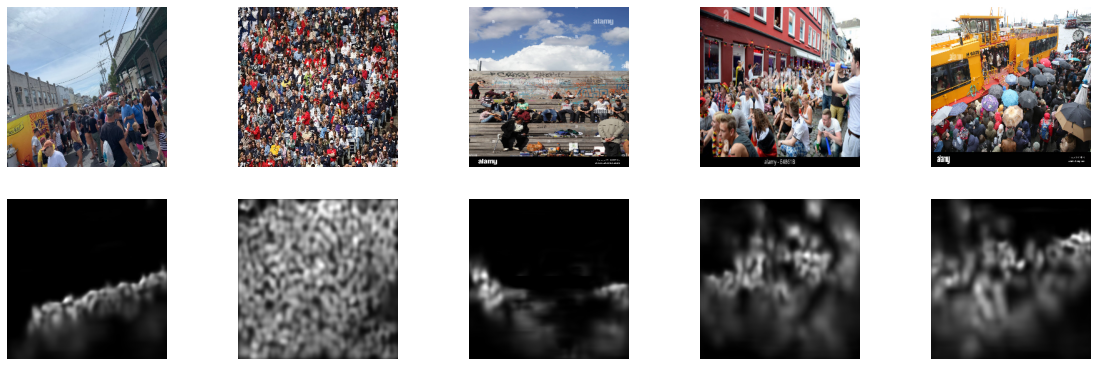

In [ ]:
# display original and prediction
plt.figure(figsize=(20, 10))

for i in range(predictions):

  # show image
  ax1 = plt.subplot(3, predictions, i+1)
  plt.imshow(cv2.cvtColor(test_data[i], cv2.COLOR_BGR2RGB))
  plt.axis("off")

  # show predicted density map
  ax2 = plt.subplot(3, predictions, i+predictions+1)
  plt.imshow(cv2.cvtColor(test_pred[i], cv2.COLOR_BGR2RGB))
  plt.axis("off")

---
---

# **2. Predicting the number of people in the image**

Now we estimate the number of people from a density map

## Building the architecture

**Needs to be run.** First we build the architecture of the model.

In [ ]:
def build_model_ppl():

  # the shape of the input
  input_shape = (256, 256, 1)

  # the layers that get added to the model
  layers_forwards  = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512]

  # build model
  model_ppl = None
  model_ppl = tf.keras.models.Sequential([])

  # scale down
  for layer in layers_forwards:

    # add max pooling layer
    if layer == 'M':
      model_ppl.add(tf.keras.layers.MaxPool2D())

    # add convolution 2d layer
    else:
      model_ppl.add(tf.keras.layers.Conv2D(layer, kernel_size = 3, dilation_rate = 2, activation = 'relu', padding='same'))

  # dense layers at the end
  model_ppl.add(tf.keras.layers.Flatten())
  model_ppl.add(tf.keras.layers.Dense(16, activation = 'relu'))
  model_ppl.add(tf.keras.layers.Dense(1, activation = 'relu'))

In [ ]:
# compile the model and give a summary
model_ppl = build_model_ppl()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model_ppl.build(input_shape = (None, 256, 256, 1))

model_ppl.compile(
    optimizer=optimizer,
    loss = 'mse',
    metrics=['mae'],
    )

model_ppl.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_228 (Conv2D)         (None, 256, 256, 64)      640       
                                                                 
 conv2d_229 (Conv2D)         (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_100 (MaxPooli  (None, 128, 128, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_230 (Conv2D)         (None, 128, 128, 128)     73856     
                                                                 
 conv2d_231 (Conv2D)         (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_101 (MaxPooli  (None, 64, 64, 128)      0         
 ng2D)                                               

---

## Training the model

We can now train the model, same as with the density maps.

(The model has already been trained, code does not need to be run again)

In [ ]:
# train the model
n_epochs = 100

history_ppl = model_ppl.fit(
    x = dmp_data_train,
    y = ppl_data_train,
    batch_size = 16,
    epochs = n_epochs,
    validation_split = 0.2,
    shuffle = True
    )

Epoch 1/100
35/35 [==============================] - 14s 376ms/step - loss: 295926.0312 - mae: 335.3774 - val_loss: 35388.1016 - val_mae: 159.3788
Epoch 2/100
35/35 [==============================] - 13s 371ms/step - loss: 142528.2812 - mae: 226.4482 - val_loss: 4048.6665 - val_mae: 41.1069
Epoch 3/100
35/35 [==============================] - 13s 373ms/step - loss: 239723.0625 - mae: 292.1927 - val_loss: 13652.4609 - val_mae: 82.9127
Epoch 4/100
35/35 [==============================] - 13s 376ms/step - loss: 134159.7031 - mae: 199.7051 - val_loss: 3722.2673 - val_mae: 34.9483
Epoch 5/100
35/35 [==============================] - 13s 376ms/step - loss: 141495.7344 - mae: 218.1678 - val_loss: 6413.7593 - val_mae: 48.5748
Epoch 6/100
35/35 [==============================] - 13s 376ms/step - loss: 57830.1836 - mae: 128.4861 - val_loss: 2714.3782 - val_mae: 30.3466
Epoch 7/100
35/35 [==============================] - 13s 378ms/step - loss: 39313.2461 - mae: 112.7600 - val_loss: 3370.2654 - v

Let's see how training improved the accuracy

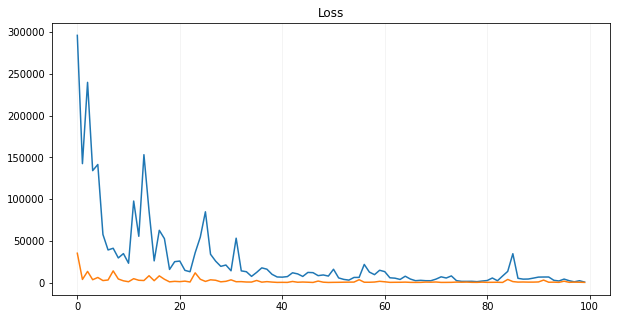

In [ ]:
# plot the history
loss_trn = history_ppl.history['loss']
loss_val = history_ppl.history['val_loss']

# display original and prediction
plt.figure(figsize=(10, 5))

ax2 = plt.subplot(1, 1, 1)
ax2.title.set_text('Loss')
plt.grid(axis='x', color='0.95')
plt.plot(loss_trn)
plt.plot(loss_val)
# plt.ylim(bottom = 0, top = 2000)

Let's also save the model so we don't have to train it again.

In [ ]:
model_ppl.save('gdrive/MyDrive/TechLabs - Group 13/Models/people-estimation-model.h5')

---

## Predicting the number of people

**Needs to be run.** We can now predict the number of people from a density map

In [ ]:
# load weights
model_ppl.load_weights('gdrive/MyDrive/TechLabs - Group 13/Models/people-estimation-model.h5')

In [ ]:
# predict values
offset = 0
prediction = 5

arr_ppl = model_ppl(dmp_data_train[offset:offset+prediction])
arr_ppl.shape

TensorShape([5, 1])

In [ ]:
# look at predicted values
for i, ppl in enumerate(arr_ppl):

  ppl_real = ppl_data_train[i + offset]
  ppl_pred = int(ppl)

  print('real:', ppl_real, 'pred:', ppl_pred, 'error:', abs(ppl_real - ppl_pred))

real: 1546 pred: 1643 error: 97
real: 920 pred: 928 error: 8
real: 371 pred: 395 error: 24
real: 298 pred: 295 error: 3
real: 184 pred: 196 error: 12


real: 1546 pred: 1643 error: 97
real: 920 pred: 928 error: 8
real: 371 pred: 395 error: 24
real: 298 pred: 295 error: 3
real: 184 pred: 196 error: 12


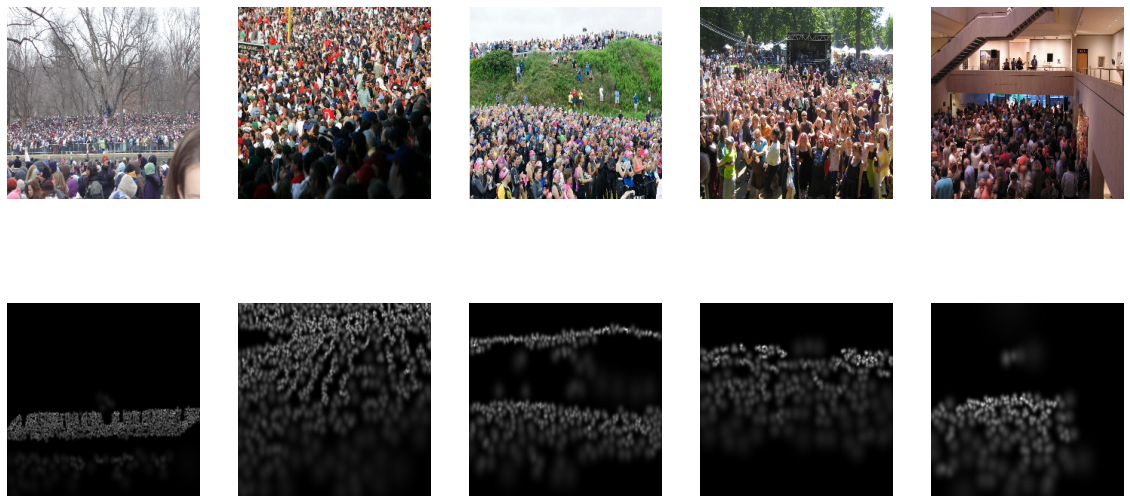

In [ ]:
# display original and prediction
plt.figure(figsize=(20, 10))

for i, ppl in enumerate(arr_ppl):

  # show image
  ax1 = plt.subplot(2, predictions, i+1)
  plt.imshow(cv2.cvtColor(img_data_train[i+offset], cv2.COLOR_BGR2RGB))
  plt.axis("off")

  # show predicted density map
  ax3 = plt.subplot(2, predictions, i+predictions+1)
  plt.imshow(cv2.cvtColor(dmp_data_train[i+offset], cv2.COLOR_BGR2RGB))
  plt.axis("off")

  ppl_real = ppl_data_train[i + offset]
  ppl_pred = int(ppl)

  print('real:', ppl_real, 'pred:', ppl_pred, 'error:', abs(ppl_real - ppl_pred))

---
---

# **3. Using both models at the same time**

We can now predict the number of people in an image using both models.

1.   Use the first model to create a density map from the image
2.   Use the second model to predict the number of people from the density map



In [ ]:
# Get paths of test images
test_path = 'gdrive/MyDrive/TechLabs - Group 13/Test Images/'
test_folder = pathlib.Path(test_path)

test_files = list(sorted(test_folder.glob('*.jpg')))
test_files = [str(i) for i in test_files]

In [ ]:
# Load and scale images
scaled_size = (256, 256)
test_img = []

for test_file in test_files:

  # load test image data
  img = cv2.imread(test_file)
  img = cv2.resize(img, scaled_size)
  img = np.array(img)

  test_img.append(img)

test_img = np.array(test_img)

In [ ]:
# predict density map
test_dmp = model_dmp.predict(test_img)

# scale density map between 0.0 and 255.0
for i in range(5):
  max_pre = np.max(test_dmp[i])

  scaling = 255. / max_pre
  test_dmp[i] = test_dmp[i] * scaling

# predict number of people
test_ppl = model_ppl.predict(test_dmp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred: 135
pred: 163
pred: 41
pred: 83
pred: 79


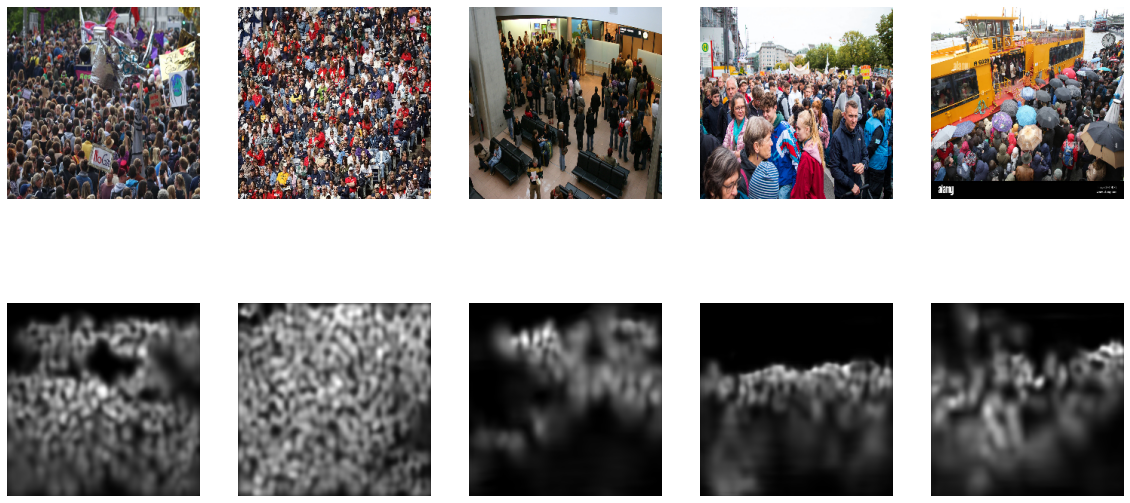

In [ ]:
# display original and prediction
plt.figure(figsize=(20, 10))

for i, ppl in enumerate(test_ppl):

  # show image
  ax1 = plt.subplot(2, predictions, i+1)
  plt.imshow(cv2.cvtColor(test_img[i], cv2.COLOR_BGR2RGB))
  plt.axis("off")

  # show predicted density map
  ax3 = plt.subplot(2, predictions, i+predictions+1)
  plt.imshow(cv2.cvtColor(test_dmp[i] / 255., cv2.COLOR_BGR2RGB))
  plt.axis("off")

  # print predicted number of people
  ppl_pred = int(ppl)
  print('pred:', ppl_pred)